In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install neurokit2
!pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 1.3 MB/s eta 0:00:00


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import biosppy.signals.ecg as ecg
import numpy as np
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy import signal

path = "/content/drive/MyDrive/DREAMER.mat"
raw = sio.loadmat(path)


In [4]:
import numpy as np
import pandas as pd
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler

def preprocess_EEG_time_domain(raw, feature):
    # Calculate time-domain features
    mean = np.mean(raw)
    std_dev = np.std(raw)
    skewness = stats.skew(raw)
    kurtosis = stats.kurtosis(raw)

    feature.append(mean)
    feature.append(std_dev)
    feature.append(skewness)
    feature.append(kurtosis)
    return feature

def feat_extract_EEG_time_domain(raw):
    num_participants = 23
    num_videos = 18
    num_channels = 14
    num_features = 4  # Mean, Std Dev, Skewness, Kurtosis
    EEG_tmp = np.zeros((num_participants, num_videos, num_channels * num_features))

    for participant in range(num_participants):
        for video in range(num_videos):
            for i in range(num_channels):
                B, S = [], []
                basl = (raw["DREAMER"][0, 0]["Data"]
                        [0, participant]["EEG"][0, 0]
                        ["baseline"][0, 0][video, 0][:, i])
                stim = (raw["DREAMER"][0, 0]["Data"]
                        [0, participant]["EEG"][0, 0]
                        ["stimuli"][0, 0][video, 0][:, i])
                B = preprocess_EEG_time_domain(basl, B)
                S = preprocess_EEG_time_domain(stim, S)
                Extrod = np.divide(S, B)
                EEG_tmp[participant, video, num_features*i:num_features*(i+1)] = Extrod

    col = []
    for i in range(num_channels):
        col.append(f"mean_{i+1}_un")
        col.append(f"std_dev_{i+1}_un")
        col.append(f"skewness_{i+1}_un")
        col.append(f"kurtosis_{i+1}_un")

    data_EEG = pd.DataFrame(EEG_tmp.reshape((num_participants * num_videos,
                                              EEG_tmp.shape[2])), columns=col)
    scaler = StandardScaler()
    for i in range(len(col)):
        data_EEG[col[i][:-3]] = scaler.fit_transform(data_EEG[[col[i]]])
    data_EEG.drop(col, axis=1, inplace=True)
    return data_EEG

def participant_affective(raw):
    a = np.zeros((23, 18, 7), dtype=object)
    for participant in range(0, 23):
        for video in range(0, 18):
            a[participant, video, 0] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Age"][0][0][0])

            a[participant, video, 1] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Gender"][0][0][0])

            a[participant, video, 2] = int(participant+1)

            a[participant, video, 3] = int(video+1)

            a[participant, video, 4] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreValence"]
                                           [0, 0][video, 0])
            a[participant, video, 5] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreArousal"]
                                           [0, 0][video, 0])
            a[participant, video, 6] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreDominance"]
                                           [0, 0][video, 0])
    b = pd.DataFrame(a.reshape((23*18, a.shape[2])),
                     columns=["age", "gender", "participant",
                              "video", "valence", "arousal", "dominance"])
    return b

# Assume 'raw' is already loaded with the necessary EEG data
df_features_time_domain = feat_extract_EEG_time_domain(raw)
df_participant_affective = participant_affective(raw)

df_participant_affective["valence"] = df_participant_affective["valence"].astype(int)
df_participant_affective["arousal"] = df_participant_affective["arousal"].astype(int)
df_participant_affective["dominance"] = df_participant_affective["dominance"].astype(int)
df = pd.concat([df_features_time_domain, df_participant_affective], axis=1)

data = df.copy()
data



,mean_1,std_dev_1,skewness_1,kurtosis_1,mean_2,std_dev_2,skewness_2,kurtosis_2,mean_3,std_dev_3,...,std_dev_14,skewness_14,kurtosis_14,age,gender,participant,video,valence,arousal,dominance
0,0.078972,-0.278388,-0.020604,-0.069875,0.185863,-0.322584,-0.643325,0.047408,0.546392,-0.472850,...,-0.457287,0.211842,-0.116104,22,male,1,1,4,3,2
1,-0.070469,-0.110870,-0.007740,-0.077030,0.071368,0.023180,0.232760,-0.033932,-0.044767,0.769401,...,-0.620344,0.005617,-0.022834,22,male,1,2,3,3,1
2,-0.228583,-0.085445,-0.036057,-0.069336,-0.119083,0.021121,-1.098617,0.047176,0.170309,0.163278,...,0.011738,-5.740220,-0.105603,22,male,1,3,5,4,4
3,-0.318846,-0.201742,-0.015337,-0.066728,-0.342092,-0.126448,-0.350559,0.047277,0.234335,-0.231640,...,-0.405401,-0.009565,-0.137296,22,male,1,4,4,3,2
4,-0.298467,-0.086567,-0.026699,-0.064326,-0.195509,-0.133407,0.338947,0.050546,4.002156,6.143943,...,0.015716,0.034256,-0.123908,22,male,1,5,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.785470,-0.348197,-0.015725,-0.058063,1.121600,-0.321252,-0.176606,0.048335,0.311117,-0.463029,...,-0.108512,-0.059899,-0.064152,25,male,23,14,2,2,2
410,0.022241,-0.053556,-0.038978,-0.049065,0.011893,0.033432,-1.165585,1.523263,-0.300072,-0.143479,...,0.462141,0.065810,0.081583,25,male,23,15,2,2,2
411,-0.253299,-0.166956,-0.030465,-0.068856,0.755750,0.039908,-0.100242,0.046887,2.285044,-0.269243,...,0.639588,0.561941,0.552946,25,male,23,16,3,3,2
412,-0.236578,-0.406442,-0.038409,-0.069762,0.715725,0.153486,-0.345873,0.046997,-0.252190,-0.243378,...,-0.154659,0.829981,-0.095888,25,male,23,17,2,2,4


In [5]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with the necessary columns

# Define a function to convert values to binary
def to_binary(value):
    if value == 1:
        return 0
    elif value in [2, 3]:
        return 1
    else:
        return 2

print("Unique values before transformation:")
print("Valence:", df["valence"].unique())
print("Arousal:", df["arousal"].unique())
print("Dominance:", df["dominance"].unique())

# Apply this function to the "valence", "arousal", and "dominance" columns
data["valence"] = df["valence"].apply(to_binary)
data["arousal"] = df["arousal"].apply(to_binary)
data["dominance"] = df["dominance"].apply(to_binary)

# Verify the changes
print(data[["valence", "arousal", "dominance"]].head())

data

Unique values before transformation:
Valence: [4 3 5 1 2]
Arousal: [3 4 2 1 5]
Dominance: [2 1 4 5 3]
   valence  arousal  dominance
0        2        1          1
1        1        1          0
2        2        2          2
3        2        1          1
4        2        2          2


,mean_1,std_dev_1,skewness_1,kurtosis_1,mean_2,std_dev_2,skewness_2,kurtosis_2,mean_3,std_dev_3,...,std_dev_14,skewness_14,kurtosis_14,age,gender,participant,video,valence,arousal,dominance
0,0.078972,-0.278388,-0.020604,-0.069875,0.185863,-0.322584,-0.643325,0.047408,0.546392,-0.472850,...,-0.457287,0.211842,-0.116104,22,male,1,1,2,1,1
1,-0.070469,-0.110870,-0.007740,-0.077030,0.071368,0.023180,0.232760,-0.033932,-0.044767,0.769401,...,-0.620344,0.005617,-0.022834,22,male,1,2,1,1,0
2,-0.228583,-0.085445,-0.036057,-0.069336,-0.119083,0.021121,-1.098617,0.047176,0.170309,0.163278,...,0.011738,-5.740220,-0.105603,22,male,1,3,2,2,2
3,-0.318846,-0.201742,-0.015337,-0.066728,-0.342092,-0.126448,-0.350559,0.047277,0.234335,-0.231640,...,-0.405401,-0.009565,-0.137296,22,male,1,4,2,1,1
4,-0.298467,-0.086567,-0.026699,-0.064326,-0.195509,-0.133407,0.338947,0.050546,4.002156,6.143943,...,0.015716,0.034256,-0.123908,22,male,1,5,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.785470,-0.348197,-0.015725,-0.058063,1.121600,-0.321252,-0.176606,0.048335,0.311117,-0.463029,...,-0.108512,-0.059899,-0.064152,25,male,23,14,1,1,1
410,0.022241,-0.053556,-0.038978,-0.049065,0.011893,0.033432,-1.165585,1.523263,-0.300072,-0.143479,...,0.462141,0.065810,0.081583,25,male,23,15,1,1,1
411,-0.253299,-0.166956,-0.030465,-0.068856,0.755750,0.039908,-0.100242,0.046887,2.285044,-0.269243,...,0.639588,0.561941,0.552946,25,male,23,16,1,1,1
412,-0.236578,-0.406442,-0.038409,-0.069762,0.715725,0.153486,-0.345873,0.046997,-0.252190,-0.243378,...,-0.154659,0.829981,-0.095888,25,male,23,17,1,1,2


In [6]:
data.isnull().sum().sum()

0

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Select columns for normalization (excluding non-numeric columns like 'participant', 'video', etc.)
columns_to_normalize = data.columns.difference(['participant', 'video', 'gender', 'valence', 'arousal', 'dominance'])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the selected columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
data['gender'].replace({'male': 1, 'female': 0}, inplace=True)
data

,mean_1,std_dev_1,skewness_1,kurtosis_1,mean_2,std_dev_2,skewness_2,kurtosis_2,mean_3,std_dev_3,...,std_dev_14,skewness_14,kurtosis_14,age,gender,participant,video,valence,arousal,dominance
0,0.352661,0.063970,0.175631,0.551405,0.349813,0.031666,0.471462,0.911529,0.334544,0.072836,...,0.049777,0.668790,0.327112,0.000000,1,1,1,2,1,1
1,0.338169,0.079764,0.176170,0.551052,0.339828,0.059303,0.536605,0.907832,0.295515,0.201172,...,0.033597,0.659700,0.331639,0.000000,1,1,2,1,1,0
2,0.322836,0.082162,0.174983,0.551432,0.323218,0.059139,0.437608,0.911518,0.309714,0.138554,...,0.096317,0.406438,0.327622,0.000000,1,1,3,2,2,2
3,0.314083,0.071196,0.175852,0.551561,0.303768,0.047343,0.493231,0.911523,0.313942,0.097755,...,0.054926,0.659031,0.326084,0.000000,1,1,4,2,1,1
4,0.316059,0.082056,0.175375,0.551680,0.316552,0.046787,0.544501,0.911671,0.562700,0.756412,...,0.096712,0.660962,0.326733,0.000000,1,1,5,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.421173,0.057388,0.175835,0.551989,0.431422,0.031772,0.506166,0.911571,0.319011,0.073851,...,0.084385,0.656812,0.329634,0.272727,1,23,14,1,1,1
410,0.347160,0.085168,0.174861,0.552433,0.334641,0.060123,0.432628,0.978606,0.278659,0.106863,...,0.141009,0.662353,0.336707,0.272727,1,23,15,1,1,1
411,0.320439,0.074476,0.175218,0.551456,0.399515,0.060640,0.511844,0.911505,0.449333,0.093870,...,0.158617,0.684221,0.359585,0.272727,1,23,16,1,1,1
412,0.322061,0.051896,0.174885,0.551411,0.396024,0.069719,0.493580,0.911510,0.281820,0.096543,...,0.079806,0.696036,0.328093,0.272727,1,23,17,1,1,2


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import RandomOverSampler

     arousal video  valence  skewness_12  skewness_3  skewness_14   mean_10  \
0          1     1        2     0.948461    0.941210     0.668790  0.414546   
1          1     2        1     0.948560    0.940955     0.659700  0.351892   
2          2     3        2     0.948311    0.940667     0.406438  0.369773   
3          1     4        2     0.948654    0.940951     0.659031  0.375200   
4          2     5        2     0.948527    0.941478     0.660962  0.370324   
..       ...   ...      ...          ...         ...          ...       ...   
409        1    14        1     0.948435    0.940877     0.656812  0.385670   
410        1    15        1     0.948270    0.940474     0.662353  0.363731   
411        1    16        1     0.948172    0.940912     0.684221  0.486663   
412        1    17        1     0.948238    0.940817     0.696036  0.385559   
413        2    18        1     0.948258    0.940858     0.650523  0.355641   

     std_dev_10    mean_3  std_dev_2  ...  gender  

<ipython-input-9-a6156987f99d>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EEG_selected_features['dominance'] = y


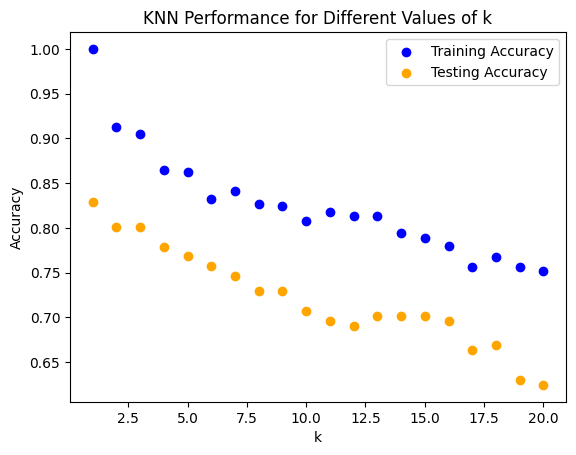

In [9]:
def evaluate_cv_model(model, data, target, kFolds):
    a_score = cross_val_score(model, data, target, cv=kFolds, scoring='accuracy')
    accuracy = a_score.mean()

    return accuracy

def plot_confusionMatrix (clf, y_test, X_test):

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    report = classification_report(y_test, y_pred)
    plt.show()

    return report

# KNN classifier
def KNN(X_train, y_train, X_test, y_test, num_neighbors):

    # create the model
    KNN = KNeighborsClassifier(n_neighbors = num_neighbors)

    # fit the model
    KNN.fit(X_train, y_train)
    train_accuracy = KNN.score(X_train, y_train)
    # get the accuracy
    test_accuracy = KNN.score(X_test, y_test)


    # predict the values
    prediction = KNN.predict(X_test)

    return test_accuracy, train_accuracy, prediction, KNN


EEG_data = data.copy()
EEG_data

def Feature_Selection(data, threshold):
    y = data.dominance
    X = data.drop('dominance', axis=1)

    importance = mutual_info_classif(X, y)
    feat_importance = pd.Series(importance, index=X.columns)

    # Sort the features
    feat_importance = feat_importance.sort_values(ascending=False)

    selected_features = []

    # Loop over sorted features
    for i in feat_importance.index:
        if feat_importance[i] > threshold:
            selected_features.append(i)

    # Create a DataFrame of the selected features
    df_selected_features = data[selected_features]
    print(df_selected_features)
    return df_selected_features

y = EEG_data.dominance
EEG_selected_features = Feature_Selection(EEG_data, 0.002)
EEG_selected_features['dominance'] = y
X_EEG_target = EEG_selected_features.drop('dominance', axis=1)
y_EEG_target = EEG_selected_features['dominance']


kf = KFold(n_splits=8, random_state=42 , shuffle = True)

def Evaluate (y_test, prediction):
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')
    return accuracy, precision, recall, f1

K = []
training = []
test = []
scores = {}



from collections import Counter

# Assuming X and y are your feature matrix and target vector
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_EEG_target, y_EEG_target)

# Before oversampling
print("Class Distribution Before Oversampling:")
print(Counter(y_EEG_target))

# After oversampling
print("\nClass Distribution After Oversampling:")
print(Counter(y_resampled))


X_train_EEG, X_test_EEG, y_train_EEG, y_test_EEG = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_EEG, y_train_EEG)
    training_score = knn.score(X_train_EEG, y_train_EEG)
    test_score = knn.score(X_test_EEG, y_test_EEG)
    K.append(k)
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

# Visualize the results
plt.scatter(K, training, label='Training Accuracy', marker='o', color='blue')
plt.scatter(K, test, label='Testing Accuracy', marker='o', color='orange')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('KNN Performance for Different Values of k')
plt.legend()
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

def train_model(X_train, y_train, model_name='RandomForest'):
    if model_name == 'RandomForest':
        # Initialize Random Forest classifier
        model = RandomForestClassifier(random_state=42)
        # Define hyperparameters to tune
        param_grid = {
            'n_estimators': [100, 200, 300],  # Number of trees in the forest
            'max_depth': [5, 10, 20],       # Maximum depth of the tree
            'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
            'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
        }
    elif model_name == 'SVM':
        # Initialize Support Vector Machine classifier
        model = svm.SVC()
        # Define hyperparameters to tune
        param_grid = {
            'C': [0.1, 1, 10],                  # Regularization parameter
            'gamma': [0.1, 0.01, 0.001],        # Kernel coefficient
            'kernel': ['rbf', 'linear', 'poly'] # Kernel type
        }
    elif model_name == 'DecisionTree':
        # Initialize Decision Tree classifier
        model = DecisionTreeClassifier(random_state=42)
        # Define hyperparameters to tune
        param_grid = {
            'max_depth': [5, 10, 20],       # Maximum depth of the tree
            'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
            'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
        }

    # Perform Grid Search Cross-Validation to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Train the best model
    best_model.fit(X_train, y_train)

    return best_model, best_params

# Train models and get best parameters
random_forest_model, rf_best_params = train_model(X_train_EEG, y_train_EEG, model_name='RandomForest')
svm_model, svm_best_params = train_model(X_train_EEG, y_train_EEG, model_name='SVM')
decision_tree_model, dt_best_params = train_model(X_train_EEG, y_train_EEG, model_name='DecisionTree')

# Print the best parameters
print("Random Forest best parameters:", rf_best_params)
print("SVM best parameters:", svm_best_params)
print("Decision Tree best parameters:", dt_best_params)


Random Forest best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
SVM best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Decision Tree best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [11]:
import pandas as pd
import time

# Define a function to evaluate models and save results to an Excel file
def evaluate_and_save_results(models, model_names, X_train, y_train, X_test, y_test, output_file):
    results = []
    for model, name in zip(models, model_names):
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        start_time = time.time()
        train_accuracy = model.score(X_train, y_train)
        test_accuracy = model.score(X_test, y_test)
        prediction = model.predict(X_test)
        prediction_time = time.time() - start_time

        accuracy, precision, recall, f1 = Evaluate(y_test, prediction)
        results.append([name, train_accuracy*100, test_accuracy*100, precision*100, recall*100, f1*100, training_time, prediction_time])

    # Evaluate KNN separately and include it in the results
    KNN_test, KNN_train, KNN_prediction, KNN_model = KNN(X_train_EEG, y_train_EEG, X_test_EEG, y_test_EEG, 3)
    KNN_accuracy, KNN_precision, KNN_recall, KNN_f1 = Evaluate(y_test_EEG, KNN_prediction)
    knn_start_time = time.time()
    KNN_model.fit(X_train_EEG, y_train_EEG)
    knn_training_time = time.time() - knn_start_time
    knn_start_time = time.time()
    knn_prediction = KNN_model.predict(X_test_EEG)
    knn_prediction_time = time.time() - knn_start_time
    results.append(["KNN", KNN_train*100, KNN_test*100, KNN_precision*100, KNN_recall*100, KNN_f1*100, knn_training_time, knn_prediction_time])

    # Create a DataFrame from the results
    df_results = pd.DataFrame(results, columns=['Model', 'Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-score', 'Training Time (s)', 'Prediction Time (s)'])

    # Save the DataFrame to an Excel file
    df_results.to_excel(output_file, index=False)

# Define your models and their names
models = [random_forest_model, svm_model, decision_tree_model]
model_names = ['RF', 'SVM', 'DT']

# Specify the file path for the output Excel file
output_file = 'ML_time_dominance_trenary_results.xlsx'

# Call the function to evaluate models and save results
evaluate_and_save_results(models, model_names, X_train_EEG, y_train_EEG, X_test_EEG, y_test_EEG, output_file)

print("Evaluation results saved to:", output_file)


Evaluation results saved to: ML_time_dominance_trenary_results.xlsx
